In [1]:
# Modify sys paths for importing development module
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

## Read profiles

In [2]:
def read_profile(fname):
    """Return the profile result of dict type
    
    Format:
        <frame_id>,<track_id>,<tl_x>,<tl_y>,<br_x>,<br_y>
    """
    profile = {}
    
    with open(fname, "r") as f:
        content = f.read()
        lines = [ line for line in content.split("\n") if len(line) > 0]
        
        for line in lines:
            fields = [ float(field) for field in line.split(",") ]
            if int(fields[0]) not in profile:
                profile[int(fields[0])] = []
            profile[int(fields[0])].append(tuple(fields[2:]))
    
    return profile

In [3]:
PROFILE_DIR = "../result/DetApp/"

# Read tracking profile
pfiles = [ osp.join(PROFILE_DIR, f) for f in os.listdir(PROFILE_DIR) if f.endswith(".txt") ]
profiles = dict([ (pfile, { 'profile': read_profile(pfile) }) for pfile in pfiles ])

print("Number of profiles:", len(profiles))
for pfile in profiles.keys():
    print("-", pfile)

Number of profiles: 3
- ../result/DetApp/gLO_sGR_c08_d13_d14_d15_mLO0_ch01.mp4.txt
- ../result/DetApp/gLO_sGR_c02_d13_d14_d15_mLO0_ch01.mp4.txt
- ../result/DetApp/gLO_sGR_c01_d13_d14_d15_mLO0_ch01.mp4.txt


## Combine video reader with profile

In [4]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [5]:
# Combine video reader
for pfile in profiles.keys():
    vfile = osp.join(PROFILE_DIR, osp.basename(pfile).rstrip(".txt"))
    cap = cv2.VideoCapture(vfile)
    profiles[pfile]['capture'] = cap

## Plot histogram diagram of detection distribution

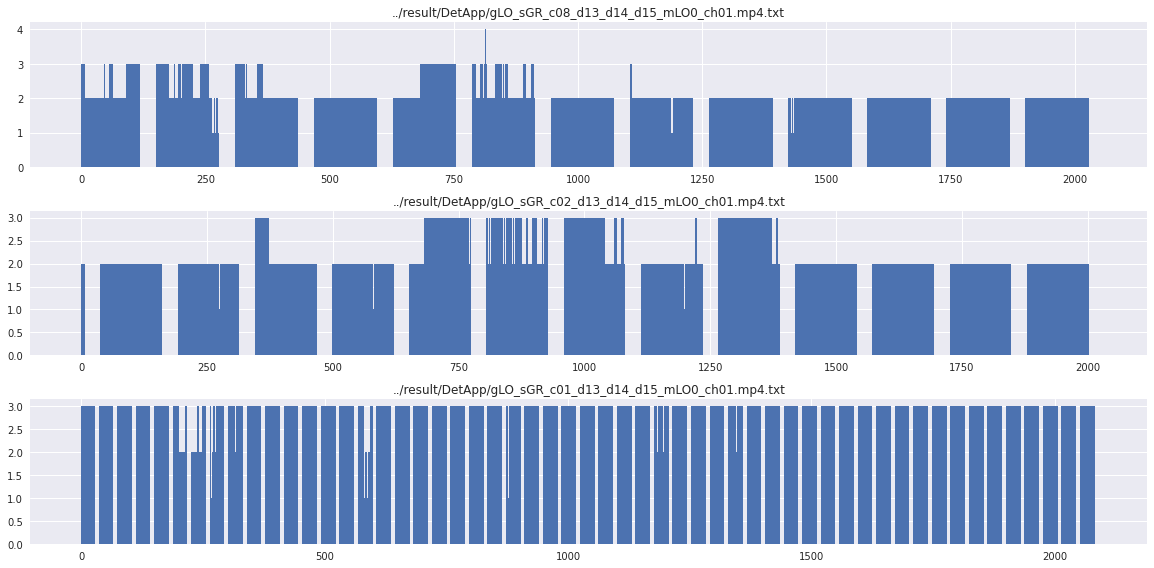

In [6]:
fig, axes = plt.subplots(nrows=len(profiles), ncols=1, figsize=(16, 8))

for idx, (pfile, result) in enumerate(profiles.items()):
    peoples = [ len(people) for people in result['profile'].values() ]
    indices = np.arange(len(peoples))
    axes[idx].bar(indices, peoples)
    axes[idx].set_title(pfile)
    
plt.tight_layout()

## Select Target Frame with same number of people

In [7]:
# Hyperparameter
TARGET_FRAME = 1300

In [8]:
from app.utils.visualize import draw_bbox, get_unique_color
from worker.motworker.utils import crop_image

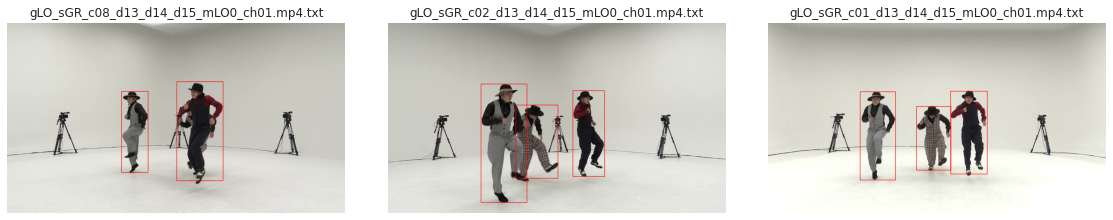

In [9]:
pfiles = list(profiles.keys())

# Visualization
fig, axes = plt.subplots(nrows=1, ncols=len(profiles), figsize=(16, 8))

# Show detected people
for idx, pfile in enumerate(pfiles):
    # Jump to target frame
    profiles[pfile]['capture'].set(cv2.CAP_PROP_POS_FRAMES, TARGET_FRAME)
    frame = profiles[pfile]['capture'].read()[1]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Draw bbox
    for bbox in profiles[pfile]['profile'][TARGET_FRAME]:
        box = np.array([ int(v) for v in bbox ])
        draw_bbox(frame, box, color=(255, 0, 0))

    # Show frame with bbox
    axes[idx].imshow(frame)
    axes[idx].set_title(osp.basename(pfile))
    axes[idx].set_axis_off()
    
plt.tight_layout()

## Show cropped images

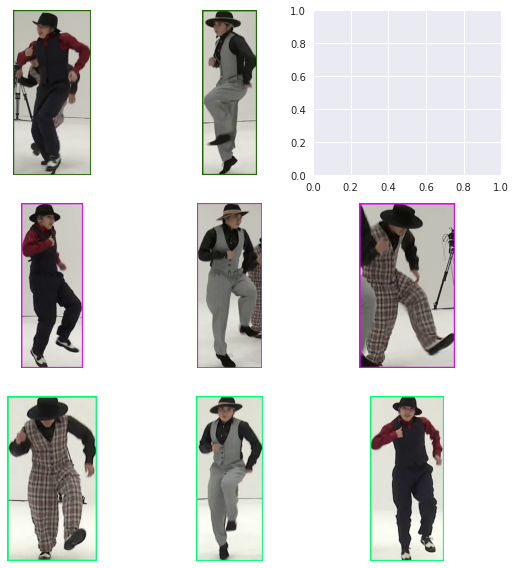

In [10]:
import re

pfiles = list(profiles.keys())
camera_regex = re.compile(r'.+_c(?P<cid>\d\d)_.+')

# Crop images
camera_people = {}
for idx, pfile in enumerate(pfiles):
    # Jump to target frame
    profiles[pfile]['capture'].set(cv2.CAP_PROP_POS_FRAMES, TARGET_FRAME)
    frame = profiles[pfile]['capture'].read()[1]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Extract Camera ID
    cid = int(camera_regex.match(osp.basename(pfile)).group('cid'))
    
    # Crop person images
    crop_imgs = []
    for bbox in profiles[pfile]['profile'][TARGET_FRAME]:
        crop_img = crop_image(frame, bbox)
        crop_imgs.append(crop_img)

    camera_people[cid] = crop_imgs
    
# Visualization
fig, axes = plt.subplots(nrows=len(camera_people),
                         ncols=max([ len(p) for p in camera_people.values() ]),
                         figsize=(8, 8))

for i, (cid, imgs) in enumerate(camera_people.items()):
    # Show cropped images
    color = get_unique_color(cid)
    for j, img in enumerate(imgs):
        draw_bbox(img, (0, 0, img.shape[1], img.shape[0]) ,color=color, thickness=5)
        axes[i][j].imshow(img)
        axes[i][j].set_axis_off()
    
plt.tight_layout()

## Map Person to embedding space

In [11]:
from colormap import rgb2hex
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from worker.recognition import get_recognizer

In [12]:
# Load recognizer model (ReID model)
recognizer = get_recognizer("Resnet18", { 'device': "cuda" })

In [13]:
pfiles = list(profiles.keys())
camera_regex = re.compile(r'.+_c(?P<cid>\d\d)_.+')

# Copmute embedding
all_crop_imgs = []
all_embeddings = []
camera_embeddings = {}
for idx, pfile in enumerate(pfiles):
    # Jump to target frame
    profiles[pfile]['capture'].set(cv2.CAP_PROP_POS_FRAMES, TARGET_FRAME)
    frame = profiles[pfile]['capture'].read()[1]
    
    # Extract Camera ID
    cid = int(camera_regex.match(osp.basename(pfile)).group('cid'))
    
    # Compute embedding of each person
    crop_imgs = []
    for bbox in profiles[pfile]['profile'][TARGET_FRAME]:
        crop_img = crop_image(frame, bbox)
        crop_imgs.append(crop_img)
        all_crop_imgs.append(crop_img)
    
    # Record embeddings
    embeddings_ = recognizer(crop_imgs)
    all_embeddings.append(embeddings_)
    camera_embeddings[cid] = embeddings_

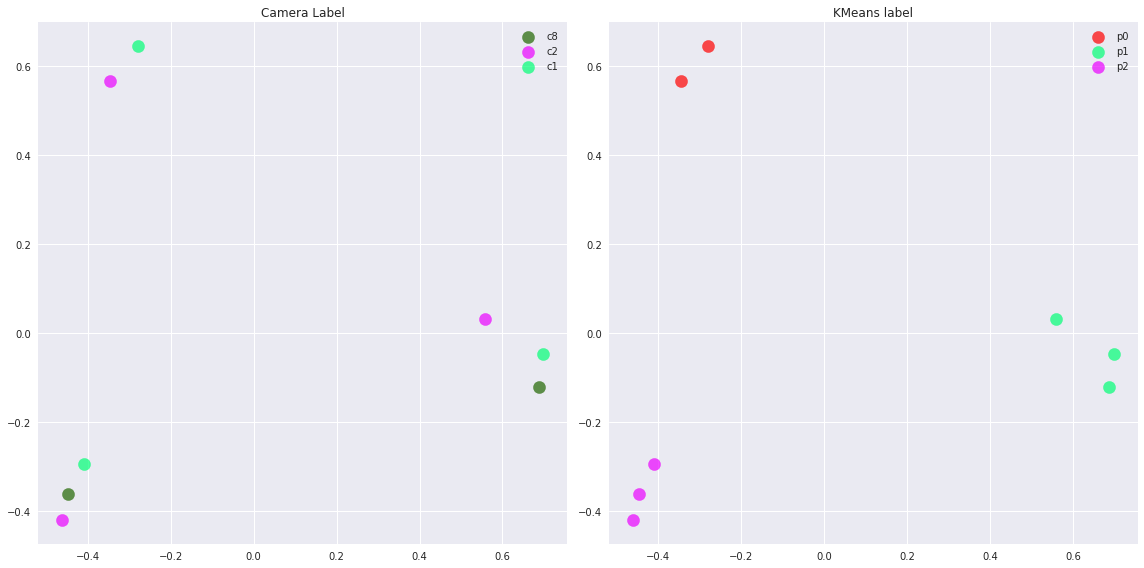

In [14]:
# Visualization Embedding
# ===============================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Dimension reduction to 2D space by PCA
embeddings = np.concatenate(all_embeddings)
pca = PCA(n_components=2)
pca = pca.fit(embeddings)

# Visualize 2D embedding space with camera id label
for i, (cid, embeddings_) in enumerate(camera_embeddings.items()):
    color = get_unique_color(cid)
    reduced = pca.transform(embeddings_)
    axes[0].scatter(x=reduced[:, 0], y=reduced[:, 1],
                s=150, c=rgb2hex(*color), alpha=0.7,
                label="c{}".format(cid))
    axes[0].legend()
    axes[0].set_title("Camera Label")

# Visualize 2D embedding space with person id labels (K-means label)
K = max([ len(embeddings_) for embeddings_ in camera_embeddings.values() ])
kmeans = KMeans(n_clusters=K)
kmeans = kmeans.fit(pca.transform(embeddings))

reduced = pca.transform(embeddings)
labels = kmeans.predict(reduced)

for label in set(labels):
    color = get_unique_color(label)
    indices = np.where(np.array(labels) == label)[0]
    target_embeddings = reduced[indices]
    axes[1].scatter(target_embeddings[:, 0], target_embeddings[:, 1],
                s=150, c=rgb2hex(*color), alpha=0.7,
                label="p{}".format(label))
    axes[1].legend()
    axes[1].set_title("KMeans label")

plt.tight_layout()

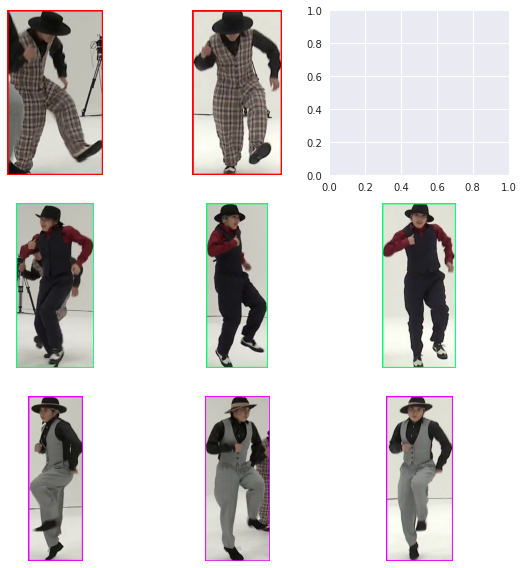

In [15]:
# Show original crop images with kmeans clustering
n_camera = len(profiles)
n_people = max([ len(embeddings_) for embeddings_ in camera_embeddings.values() ])

fig, axes = plt.subplots(nrows=n_people, ncols=n_camera, figsize=(8, 8))
for i, label in enumerate(set(labels)):
    color = get_unique_color(label)
    indices = np.where(np.array(labels) == label)[0]
    
    for j, pidx in enumerate(indices):
        crop_img = all_crop_imgs[pidx]
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        draw_bbox(crop_img, (0, 0, crop_img.shape[1], crop_img.shape[0]), color=color, thickness=5)
        axes[i][j].imshow(crop_img)
        axes[i][j].set_axis_off()
        
plt.tight_layout()

## Apply graph message passing to refine embedding

In [28]:
# Node embedding
nodes = np.matrix(embeddings)

# Adjancency matrix
A = np.dot(embeddings, embeddings.T)
A[A > 0.7] = 1
A[A < 0.7] = 0
A = np.matrix(A)
print("A\n", A)

# Degree matrix
D = np.matrix(np.diag(np.asarray(A.sum(axis=1)).ravel()))
print("D\n", D)

A
 [[1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1.]]
D
 [[3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3.]]


In [25]:
# Run T times message passing
T = 3

# Graph message propagation formula: X = D^{-1}*A*X
X = nodes.copy()
for i in range(T):
    X = (D**-1)*A*X
    
# Refined embeddings
refined_embeddings = X

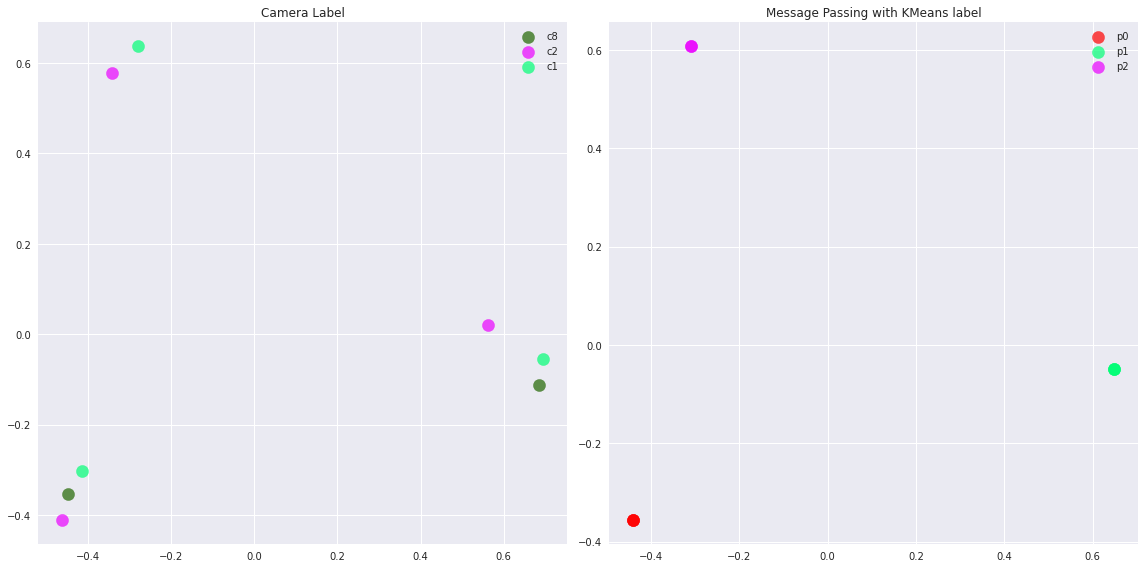

In [26]:
# Visualization Embedding
# ===============================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Dimension reduction to 2D space by PCA
pca = PCA(n_components=2)
pca = pca.fit(refined_embeddings)

# Visualize 2D embedding space with camera id label
for i, (cid, embeddings_) in enumerate(camera_embeddings.items()):
    color = get_unique_color(cid)
    reduced = pca.transform(embeddings_)
    axes[0].scatter(x=reduced[:, 0], y=reduced[:, 1],
                s=150, c=rgb2hex(*color), alpha=0.7,
                label="c{}".format(cid))
    axes[0].legend()
    axes[0].set_title("Camera Label")

# Visualize 2D embedding space with person id labels (K-means label)
K = max([ len(embeddings_) for embeddings_ in camera_embeddings.values() ])
kmeans = KMeans(n_clusters=K)
kmeans = kmeans.fit(pca.transform(refined_embeddings))

reduced = pca.transform(refined_embeddings)
labels = kmeans.predict(reduced)

for label in set(labels):
    color = get_unique_color(label)
    indices = np.where(np.array(labels) == label)[0]
    target_refined_embeddings = reduced[indices]
    axes[1].scatter(target_refined_embeddings[:, 0], target_refined_embeddings[:, 1],
                s=150, c=rgb2hex(*color), alpha=0.7,
                label="p{}".format(label))
    axes[1].legend()
    axes[1].set_title("Message Passing with KMeans label")

plt.tight_layout()

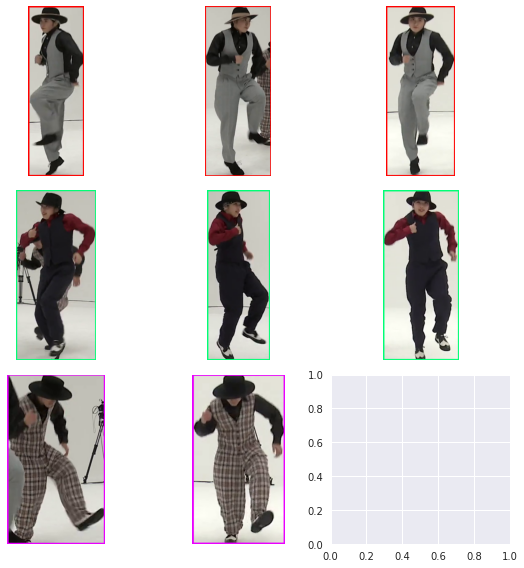

In [29]:
# Show original crop images with kmeans clustering
n_camera = len(profiles)
n_people = max([ len(embeddings_) for embeddings_ in camera_embeddings.values() ])

fig, axes = plt.subplots(nrows=n_people, ncols=n_camera, figsize=(8, 8))
for i, label in enumerate(set(labels)):
    color = get_unique_color(label)
    indices = np.where(np.array(labels) == label)[0]
    
    for j, pidx in enumerate(indices):
        crop_img = all_crop_imgs[pidx]
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        draw_bbox(crop_img, (0, 0, crop_img.shape[1], crop_img.shape[0]), color=color, thickness=5)
        axes[i][j].imshow(crop_img)
        axes[i][j].set_axis_off()
        
plt.tight_layout()